In [16]:
import os
import torch
import wandb
import cv2 as cv
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader, ConcatDataset, Subset

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [18]:
Classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
           'dot', 'minus', 'plus', 'slash', 'x', 'y', 'z', 'w')

In [19]:
class Mydataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(data_dir) if file.endswith(".png")]

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.data_dir, image_name)
        image = cv.imread(image_path)

        label = image_name.split("-")[0]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.image_files)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])


In [20]:
dataset = Mydataset(data_dir="/content/symbols", transform=transform)
train_dataset, val_dataset, test_dataset = random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)*0.2), int(len(dataset)*0.1)])

In [21]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [22]:
def plot_class_distribution(dataset, title):
    class_counts = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0,
                    "6":0, "7":0, "8":0, "9":0, "x":0, "y":0,
                    "w":0, "z":0, "dot":0, "slash":0, "plus":0,
                    "minus":0}

    for _, label in dataset:
        class_counts[label] += 1

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.show()

**همانطور که در تصویر زیر میتوان دید، تعداد فراروانی در هر کلاس با کلاس دیگر متفاوت است(این موضوع برای وقتی صدق میکند که تعداد داده ها کم باشد، اگر زیاد باشد خیلی فرقی ندارد واقعا و تقریبا تعداد برابر هست) برای مثال در داده های تست، تعداد داده های حرف 8 خیلی بیشتر 4 هست**

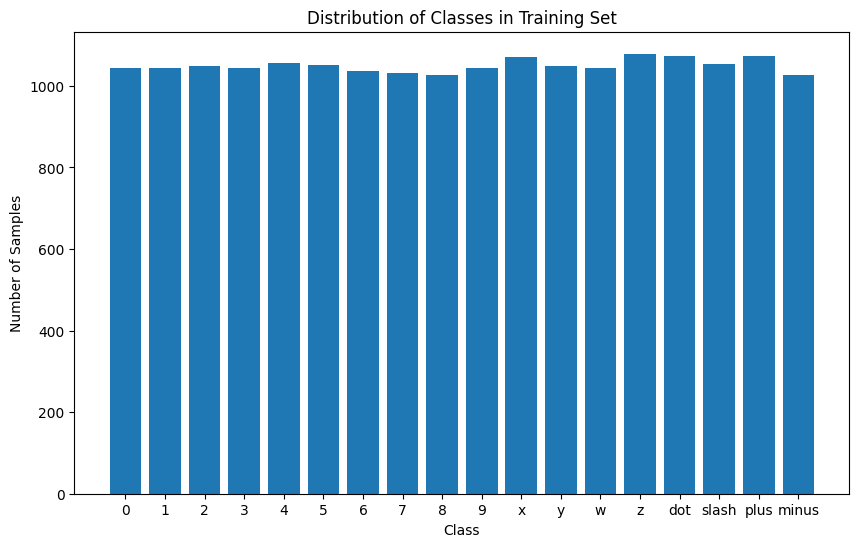

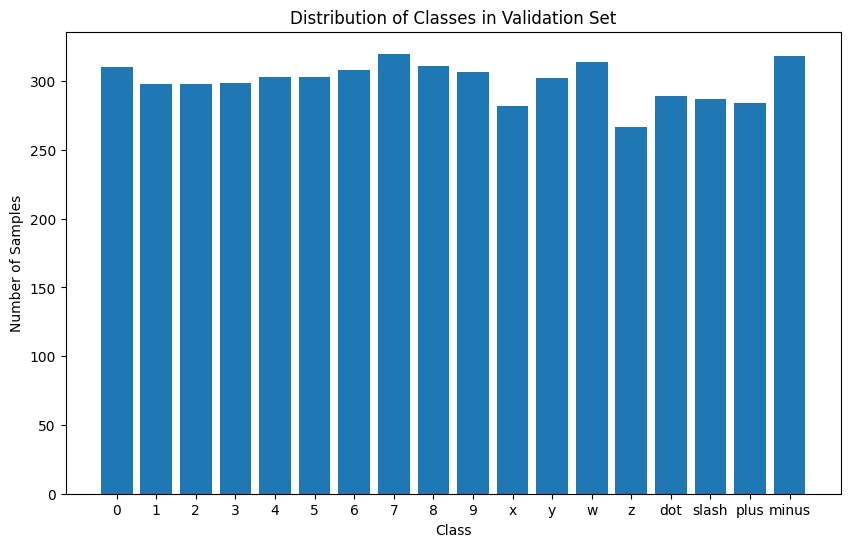

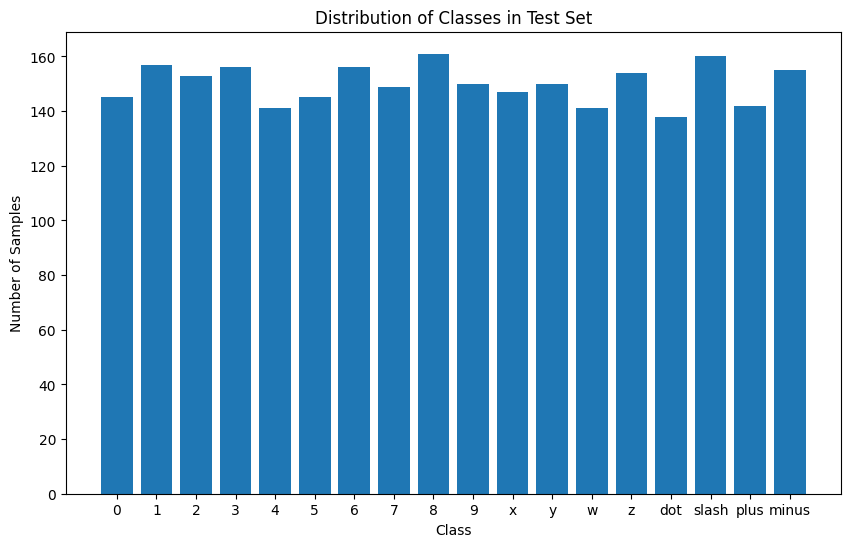

In [23]:
plot_class_distribution(train_dataset, "Distribution of Classes in Training Set")
plot_class_distribution(val_dataset, "Distribution of Classes in Validation Set")
plot_class_distribution(test_dataset, "Distribution of Classes in Test Set")

In [24]:
def split_dataset_by_class(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    set_index = {}
    for idx, data in enumerate(dataset):
        label = data[1]
        if label not in set_index:
            set_index[label] = []
        set_index[label].append(idx)

    train_index, val_index, test_index = [], [], []
    for label, index in set_index.items():
        train_index.extend(index[:int(train_ratio * len(index))])
        val_index.extend(index[int(train_ratio * len(index)):int(train_ratio * len(index)) + int(val_ratio * len(index))])
        test_index.extend(index[int(train_ratio * len(index)) + int(val_ratio * len(index)):])

    train_dataset = [dataset[i] for i in train_index]
    val_dataset = [dataset[i] for i in val_index]
    test_dataset = [dataset[i] for i in test_index]

    return train_dataset, val_dataset, test_dataset

In [25]:
train_dataset, val_dataset, test_dataset = split_dataset_by_class(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

با روش جدید میتوان دید که تعداد در همه کلاس ها مساوی و برابر است

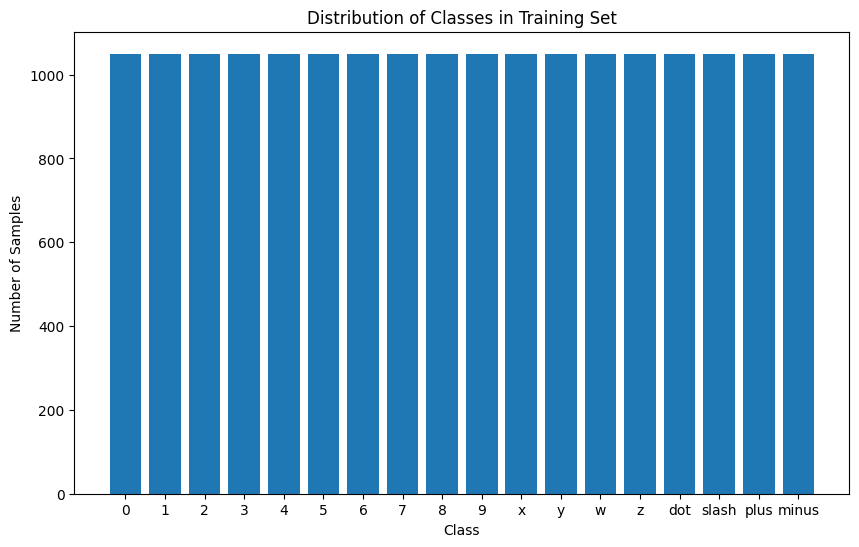

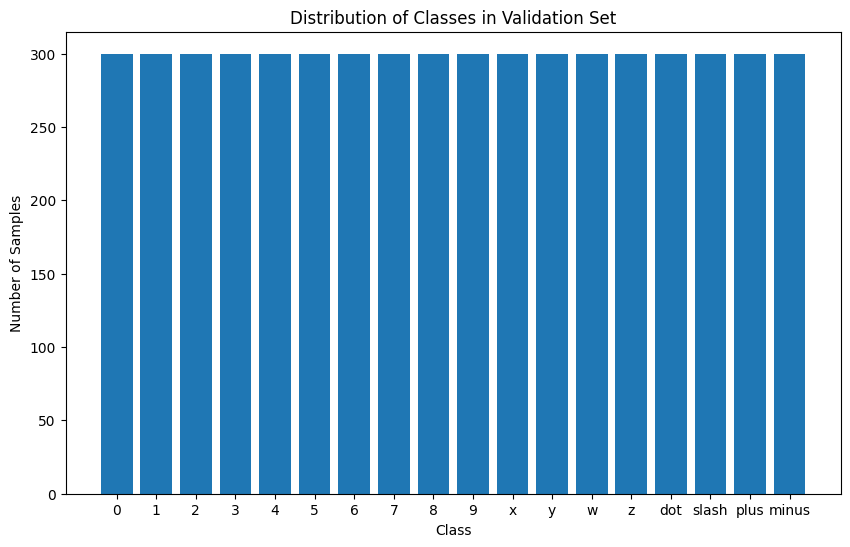

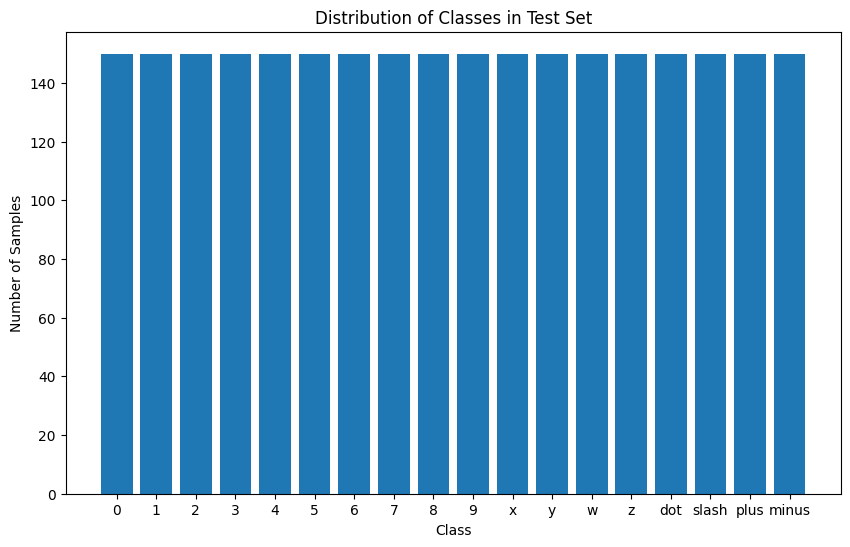

In [26]:
plot_class_distribution(train_dataset, "Distribution of Classes in Training Set")
plot_class_distribution(val_dataset, "Distribution of Classes in Validation Set")
plot_class_distribution(test_dataset, "Distribution of Classes in Test Set")

**Underfit**

پیچیدگی مدل: مدل بسیار ساده است. فقط یک لایه خطی دارد که کافی نیست برای یاد گرفتن الگوها و روابط پیچیده در داده‌های تصویری

عدم وجود لایه‌های پنهان: عدم وجود لایه‌های پنهان، توانایی مدل را در یادگیری روابط غیرخطی بین ویژگی‌ها محدود می‌کند

عدم استفاده از توابع فعال‌ساز غیرخطی: لایه‌های خطی بدون استفاده از توابع فعال‌ساز غیرخطی  توانایی مدل را در یادگیری مرزهای تصمیم پیچیده محدود می‌کند

In [27]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(28*28, 18)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x

Simpel_Model = SimpleNN()

**Overfit**

مدل از چندین لایه کانولوشن و لایه های کاملاً متصل با تعداد زیادی پارامتر استفاده می کند که باعث میشود خیلی داده های اموزش را خوب یادبگیرید(در اصل  دارد آنها را حفظ میکند، وقتی این مدل را با تعداد ایپاک خیلی بالا اموزش  میدهیم) اما وقتی که داده های تست را به انها بدهیم نتیجه خیلی جالبی به ما نخواهد داد(مگر اینکه داده ها را زیاد کنیم) همچنین  برای مثال از دراپ آوت هم استفاده نمیکند

In [28]:
class ComplexCNN(nn.Module):
    def __init__(self, num_classes):
        super(ComplexCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 64)
        self.fc8 = nn.Linear(64, 32)
        self.fc9 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fc9(x)

        return x

**Bestfit**

اما در مدل زیر نه خیلی پیچیده و نه ساده است، هایپر پارامتر های کمتری نسبت به مدل پیچیده دارد، همچنین از تکنیک دارپ آوت برای جلو گیری از اورفیت شدن استفاده میکند

In [29]:
class BestFitModel(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.25):
        super(BestFitModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(128 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout(x)
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [30]:
class_to_idx = {cls: i for i, cls in enumerate(Classes)}

In [31]:
def epoch_one_train(model, train_loader, val_loader, optimizer, criterion, class_to_idx, lr):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        label_idxs = [class_to_idx[label] for label in labels]
        label_tensor = torch.tensor(label_idxs).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, label_tensor)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss = train_loss/len(train_loader)
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            label_idxs = [class_to_idx[label] for label in labels]
            label_tensor = torch.tensor(label_idxs).to(device)

            outputs = model(images)
            loss = criterion(outputs, label_tensor)
            val_loss += loss.item()

    val_loss = val_loss/len(val_loader)
    return train_loss, val_loss

In [34]:
def train(data_loaders, model, optimizer, criterion, epochs, class_to_idx, early_stopping_patience, lr):
    best_val_loss = torch.inf
    epochs_without_improvement = 0
    total_samples = len(data_loaders.dataset)
    split_1_size = int(0.2 * total_samples)

    for epoch in range(epochs):
        train_loss =0; val_loss=0
        for i in range(5):
            start_index = i * split_1_size
            end_index = start_index + split_1_size

            split_1_indices = list(range(start_index, end_index))
            split_2_indices = list(range(0, start_index)) + list(range(end_index, total_samples))

            validation_loader = DataLoader(Subset(data_loaders.dataset, split_1_indices), batch_size=32, shuffle=True)
            train_loader_ = DataLoader(Subset(data_loaders.dataset, split_2_indices), batch_size=32, shuffle=True)

            temp_train_loss, temp_val_loss = epoch_one_train(model, train_loader_,
                                                   validation_loader, optimizer,
                                                   criterion, class_to_idx, lr)
            train_loss += temp_train_loss
            val_loss += temp_val_loss

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/5:.4f}, Val Loss: {val_loss/5:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break
    return model

In [35]:
def calculate_accuracy(model, test_loader, class_to_idx):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            label_idxs = [class_to_idx[label] for label in labels]
            label_tensor = torch.tensor(label_idxs).to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += label_tensor.size(0)
            correct += (predicted == label_tensor).sum().item()

    accuracy = correct / total
    return accuracy

In [51]:
def find_best_alpha(train_loader, val_loader, model, optimizer, criterion, epochs, class_to_idx, early_stopping_patience, lr):
    best_train_loss = torch.inf
    epochs_without_improvement = 0
    wandb.init(config={"learning_rate": lr})

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            label_idxs = [class_to_idx[label] for label in labels]
            label_tensor = torch.tensor(label_idxs).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, label_tensor)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                label_idxs = [class_to_idx[label] for label in labels]
                label_tensor = torch.tensor(label_idxs).to(device)

                outputs = model(images)
                loss = criterion(outputs, label_tensor)

                val_loss += loss.item()

        val_loss /= len(val_loader)

        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_train_loss:
            best_train_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break

    test_accuracy = calculate_accuracy(model, test_loader, class_to_idx)
    wandb.run.summary["test_accuracy"] = test_accuracy

    wandb.finish()
    return model


In [52]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep2p',
    'metric': {
        'goal': 'minimize',
        'name': 'loss'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.0001, 0.00005]
        }
    }
}

sweep_id = wandb.sweep(sweep_configuration)

Create sweep with ID: bp0191dl
Sweep URL: https://wandb.ai/ali_taheri/uncategorized/sweeps/bp0191dl


In [53]:
def sweep_agent():
    wandb.init()
    config = wandb.config

    model = BestFitModel(num_classes=18).to(device)
    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    model = find_best_alpha(
        train_loader,
        val_loader,
        model,
        optimizer,
        loss_fn,
        epochs=200,
        class_to_idx=class_to_idx,
        early_stopping_patience=3,
        lr=config.learning_rate
    )

wandb.agent(sweep_id, function=sweep_agent, count=2)

wandb: Agent Starting Run: rhyzz30w with config:
wandb: 	learning_rate: 0.0001


Epoch 1/200, Train Loss: 1.0085, Val Loss: 0.3780
Epoch 2/200, Train Loss: 0.3290, Val Loss: 0.2036
Epoch 3/200, Train Loss: 0.2063, Val Loss: 0.1458
Epoch 4/200, Train Loss: 0.1536, Val Loss: 0.1191
Epoch 5/200, Train Loss: 0.1272, Val Loss: 0.1061
Epoch 6/200, Train Loss: 0.1042, Val Loss: 0.0973
Epoch 7/200, Train Loss: 0.0922, Val Loss: 0.0877
Epoch 8/200, Train Loss: 0.0818, Val Loss: 0.0771
Epoch 9/200, Train Loss: 0.0706, Val Loss: 0.0709
Epoch 10/200, Train Loss: 0.0595, Val Loss: 0.0722
Epoch 11/200, Train Loss: 0.0556, Val Loss: 0.0653
Epoch 12/200, Train Loss: 0.0479, Val Loss: 0.0663
Epoch 13/200, Train Loss: 0.0440, Val Loss: 0.0650
Epoch 14/200, Train Loss: 0.0385, Val Loss: 0.0697
Epoch 15/200, Train Loss: 0.0365, Val Loss: 0.0631
Epoch 16/200, Train Loss: 0.0340, Val Loss: 0.0599
Epoch 17/200, Train Loss: 0.0282, Val Loss: 0.0573
Epoch 18/200, Train Loss: 0.0279, Val Loss: 0.0573
Epoch 19/200, Train Loss: 0.0246, Val Loss: 0.0594
Epoch 20/200, Train Loss: 0.0242, Val Lo

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.98296
train_loss,0.02159
val_loss,0.06307


wandb: Agent Starting Run: fas2i1mb with config:
wandb: 	learning_rate: 0.0001


Epoch 1/200, Train Loss: 1.0796, Val Loss: 0.4518
Epoch 2/200, Train Loss: 0.3755, Val Loss: 0.2433
Epoch 3/200, Train Loss: 0.2258, Val Loss: 0.1623
Epoch 4/200, Train Loss: 0.1692, Val Loss: 0.1332
Epoch 5/200, Train Loss: 0.1319, Val Loss: 0.1187
Epoch 6/200, Train Loss: 0.1139, Val Loss: 0.1060
Epoch 7/200, Train Loss: 0.0993, Val Loss: 0.0858
Epoch 8/200, Train Loss: 0.0849, Val Loss: 0.0862
Epoch 9/200, Train Loss: 0.0745, Val Loss: 0.0769
Epoch 10/200, Train Loss: 0.0672, Val Loss: 0.0749
Epoch 11/200, Train Loss: 0.0568, Val Loss: 0.0750
Epoch 12/200, Train Loss: 0.0553, Val Loss: 0.0700
Epoch 13/200, Train Loss: 0.0465, Val Loss: 0.0648
Epoch 14/200, Train Loss: 0.0434, Val Loss: 0.0651
Epoch 15/200, Train Loss: 0.0403, Val Loss: 0.0656
Epoch 16/200, Train Loss: 0.0376, Val Loss: 0.0642
Epoch 17/200, Train Loss: 0.0330, Val Loss: 0.0716
Epoch 18/200, Train Loss: 0.0299, Val Loss: 0.0625
Epoch 19/200, Train Loss: 0.0269, Val Loss: 0.0683
Epoch 20/200, Train Loss: 0.0281, Val Lo

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.98222
train_loss,0.02255
val_loss,0.06291


همانطور که مشخص است از نمودار های ابزار وان دی بی میتوان متوجه شد که مدل دوم
یکمی بهتر از مدل اول است(تفاوت صرفا در نرخ یادگیری است)
پس با همان نرخ یادگیری مدل را ترین میکنیم

1. Directly Measures Classification Accuracy:
   - Unlike mean squared error (MSE) that penalizes errors in a continuous fashion, cross-entropy loss directly focuses on the task of classifying correctly. It punishes incorrect predictions more heavily than correct ones.

2. Handles Multiple Classes:
   - Cross-entropy is highly effective for multi-class classification problems (where you have more than two classes). For example, image recognition with thousands of potential object categories

In [39]:
combined_dataset = ConcatDataset([train_dataset, val_dataset])
data_loaders = DataLoader(combined_dataset, batch_size=32, shuffle=True)

model = BestFitModel(num_classes=18).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f"Training with Learning Rate: {0.0001}")
myModel = train(data_loaders, model, optimizer, criterion, epochs=200, class_to_idx=class_to_idx, early_stopping_patience=3, lr=0.0001)

Training with Learning Rate: 0.0001
Epoch 1/200, Train Loss: 0.3640, Val Loss: 0.3459
Epoch 2/200, Train Loss: 0.0855, Val Loss: 0.1184
Epoch 3/200, Train Loss: 0.0504, Val Loss: 0.0640
Epoch 4/200, Train Loss: 0.0331, Val Loss: 0.0488
Epoch 5/200, Train Loss: 0.0230, Val Loss: 0.0296
Epoch 6/200, Train Loss: 0.0179, Val Loss: 0.0136
Epoch 7/200, Train Loss: 0.0138, Val Loss: 0.0107
Epoch 8/200, Train Loss: 0.0109, Val Loss: 0.0113
Epoch 9/200, Train Loss: 0.0093, Val Loss: 0.0079
Epoch 10/200, Train Loss: 0.0075, Val Loss: 0.0090
Epoch 11/200, Train Loss: 0.0063, Val Loss: 0.0067
Epoch 12/200, Train Loss: 0.0056, Val Loss: 0.0046
Epoch 13/200, Train Loss: 0.0049, Val Loss: 0.0030
Epoch 14/200, Train Loss: 0.0043, Val Loss: 0.0033
Epoch 15/200, Train Loss: 0.0041, Val Loss: 0.0045
Epoch 16/200, Train Loss: 0.0042, Val Loss: 0.0018
Epoch 17/200, Train Loss: 0.0031, Val Loss: 0.0030
Epoch 18/200, Train Loss: 0.0029, Val Loss: 0.0016
Epoch 19/200, Train Loss: 0.0027, Val Loss: 0.0013
Epoc

# **BestFit model**

In [40]:
accuracy = calculate_accuracy(myModel, test_loader, class_to_idx)
print(f"Accuracy on test set: {accuracy*100:.4f}%")

Accuracy on test set: 98.6296%


بر روی داده های ارزیابی هم تست را انجام میدهیم


In [41]:
accuracy = calculate_accuracy(myModel, val_loader, class_to_idx)
print(f"Accuracy on validation set: {accuracy*100:.4f}%")

Accuracy on validation set: 100.0000%


 و در آخر هم بر روی داده های آموزش

In [42]:
accuracy = calculate_accuracy(myModel, train_loader, class_to_idx)
print(f"Accuracy on validation set: {accuracy*100:.4f}%")

Accuracy on validation set: 100.0000%


# **OverFit model**

In [43]:
Cp_model = ComplexCNN(num_classes=18).to(device)
optimizer = optim.Adam(Cp_model.parameters(), lr=0.0001)
print(f"Training with Learning Rate: {0.0001}")
C_Model = train(data_loaders, Cp_model, optimizer, criterion, epochs=200, class_to_idx=class_to_idx, early_stopping_patience=3, lr=0.0001)

Training with Learning Rate: 0.0001
Epoch 1/200, Train Loss: 1.7711, Val Loss: 2.6838
Epoch 2/200, Train Loss: 0.7826, Val Loss: 1.3650
Epoch 3/200, Train Loss: 0.4113, Val Loss: 0.6339
Epoch 4/200, Train Loss: 0.2430, Val Loss: 0.3848
Epoch 5/200, Train Loss: 0.1518, Val Loss: 0.2529
Epoch 6/200, Train Loss: 0.0989, Val Loss: 0.1495
Epoch 7/200, Train Loss: 0.0665, Val Loss: 0.1242
Epoch 8/200, Train Loss: 0.0490, Val Loss: 0.0507
Epoch 9/200, Train Loss: 0.0373, Val Loss: 0.0461
Epoch 10/200, Train Loss: 0.0297, Val Loss: 0.0738
Epoch 11/200, Train Loss: 0.0238, Val Loss: 0.0305
Epoch 12/200, Train Loss: 0.0212, Val Loss: 0.0633
Epoch 13/200, Train Loss: 0.0164, Val Loss: 0.0201
Epoch 14/200, Train Loss: 0.0176, Val Loss: 0.0325
Epoch 15/200, Train Loss: 0.0153, Val Loss: 0.0129
Epoch 16/200, Train Loss: 0.0108, Val Loss: 0.0101
Epoch 17/200, Train Loss: 0.0110, Val Loss: 0.0319
Epoch 18/200, Train Loss: 0.0106, Val Loss: 0.0130
Epoch 19/200, Train Loss: 0.0095, Val Loss: 0.0118
Earl

In [44]:
accuracy = calculate_accuracy(C_Model, test_loader, class_to_idx)
print(f"Accuracy on test set: {accuracy*100:.4f}%")

Accuracy on test set: 96.1481%


بر روی داده های ارزیابی هم تست را انجام میدهیم


In [45]:
accuracy = calculate_accuracy(C_Model, val_loader, class_to_idx)
print(f"Accuracy on validation set: {accuracy*100:.4f}%")

Accuracy on validation set: 99.9259%


 و در آخر هم بر روی داده های آموزش

In [46]:
accuracy = calculate_accuracy(C_Model, train_loader, class_to_idx)
print(f"Accuracy on validation set: {accuracy*100:.4f}%")

Accuracy on validation set: 99.9259%


**که شاهد کاهش دقت بر روی داده های تست هستیم، که این نشان دهنده اورفیت بودن مدل است(دلایل هم بالای خود کلاس توضیح داده شده است)**

# **UnderFit model**

In [47]:
Un_model = SimpleNN().to(device)
optimizer = optim.Adam(Un_model.parameters(), lr=0.0001)
print(f"Training with Learning Rate: {0.0001}")
UN_Model = train(data_loaders, Un_model, optimizer, criterion, epochs=200, class_to_idx=class_to_idx, early_stopping_patience=3, lr=0.0001)

Training with Learning Rate: 0.0001
Epoch 1/200, Train Loss: 1.3805, Val Loss: 2.0192
Epoch 2/200, Train Loss: 0.7466, Val Loss: 1.1675
Epoch 3/200, Train Loss: 0.5972, Val Loss: 0.9104
Epoch 4/200, Train Loss: 0.5234, Val Loss: 0.7915
Epoch 5/200, Train Loss: 0.4783, Val Loss: 0.7368
Epoch 6/200, Train Loss: 0.4471, Val Loss: 0.6822
Epoch 7/200, Train Loss: 0.4239, Val Loss: 0.6628
Epoch 8/200, Train Loss: 0.4060, Val Loss: 0.6283
Epoch 9/200, Train Loss: 0.3912, Val Loss: 0.6230
Epoch 10/200, Train Loss: 0.3788, Val Loss: 0.5751
Epoch 11/200, Train Loss: 0.3685, Val Loss: 0.5672
Epoch 12/200, Train Loss: 0.3596, Val Loss: 0.5519
Epoch 13/200, Train Loss: 0.3512, Val Loss: 0.5435
Epoch 14/200, Train Loss: 0.3443, Val Loss: 0.5336
Epoch 15/200, Train Loss: 0.3384, Val Loss: 0.5264
Epoch 16/200, Train Loss: 0.3322, Val Loss: 0.5087
Epoch 17/200, Train Loss: 0.3266, Val Loss: 0.5000
Epoch 18/200, Train Loss: 0.3220, Val Loss: 0.5005
Epoch 19/200, Train Loss: 0.3174, Val Loss: 0.5119
Epoc

In [48]:
accuracy = calculate_accuracy(Un_model, test_loader, class_to_idx)
print(f"Accuracy on test set: {accuracy*100:.4f}%")

Accuracy on test set: 90.1852%


بر روی داده های ارزیابی هم تست را انجام میدهیم


In [49]:
accuracy = calculate_accuracy(Un_model, val_loader, class_to_idx)
print(f"Accuracy on test set: {accuracy*100:.4f}%")

Accuracy on test set: 92.4259%


 و در آخر هم بر روی داده های آموزش

In [50]:
accuracy = calculate_accuracy(Un_model, train_loader, class_to_idx)
print(f"Accuracy on test set: {accuracy*100:.4f}%")

Accuracy on test set: 91.8095%


**با استفاده از نتایج بدست آمده( و حتی لاس ها) به راحتی میتوان فهمید که مدل آندرفیت است، دلایل هم در بالای خود کلاس مربوطه ذکر شده**